In [1]:
# Baseline F1 score, logit 
# micro 0.6571099717484566
# macro 0.3165340400405846

# Costa Rican Household Poverty Prediciton
### Ben Branchflower

This is a notebook that will make predictions of the classification of poverty levels of costa rican families

### sources
[A Complete Introduction and Walkthrough](https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough) Author: Will Koehrson


In [2]:
# some imports for getting and cleaning data
import collections
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from scipy.special import boxcox1p
# feature creation and assessment
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
# the models I will be using
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

%matplotlib inline

# This is a function to separate the categorical variables from numerics so I can work with them differently
def get_feature_groups(df):
    """Returns lists of numerical and categorical features"""
    # Numerical Features
    num_features = df.select_dtypes(include=['int64','float64']).columns

    # Categorical Features
    cat_features = train.select_dtypes(include=['object']).columns
    return list(num_features), list(cat_features)

In [3]:
train = pd.read_csv('poverty_train.csv')
train_id = train.Id
train.drop(columns=['Id'], inplace=True)
test = pd.read_csv('poverty_test.csv')
test_id = test.Id
test.drop(columns=['Id'], inplace=True)

In [4]:
train.head()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,190000.0,0,3,0,1,1,0,NaN,0,1,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,135000.0,0,4,0,1,1,1,1.0,0,1,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,NaN,0,8,0,1,1,0,NaN,0,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,180000.0,0,5,0,1,1,1,1.0,0,2,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,180000.0,0,5,0,1,1,1,1.0,0,2,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 142 entries, v2a1 to Target
dtypes: float64(8), int64(130), object(4)
memory usage: 10.4+ MB


In [6]:
test.head()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,NaN,0,5,0,1,1,0,NaN,1,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,NaN,0,5,0,1,1,0,NaN,1,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,NaN,0,5,0,1,1,0,NaN,1,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,NaN,0,14,0,1,1,1,1.0,0,1,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,175000.0,0,4,0,1,1,1,1.0,0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


Let's look at the distribution of the target variable and start to get a feel for the variable we are trying to predict.

[Text(0,0,'Extreme Poverty'),
 Text(0,0,'Moderate Poverty'),
 Text(0,0,'Vulnerable'),
 Text(0,0,'NonVulnerable')]

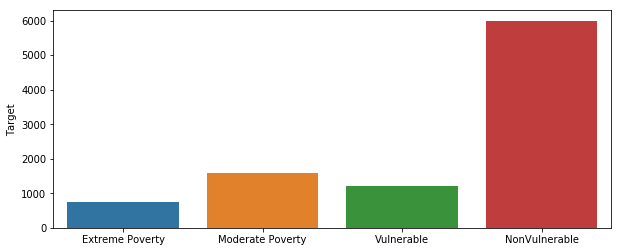

In [7]:
plt.figure(figsize=(10,4))
p = sns.barplot(train.Target.value_counts().index, train.Target.value_counts(), orient='v')
p.set_xticklabels(['Extreme Poverty', 'Moderate Poverty', 'Vulnerable', 'NonVulnerable'])

In [8]:
train.Target.value_counts()

4    5996
2    1597
3    1209
1     755
Name: Target, dtype: int64

It looks like we have pretty imbalanced data with many more families classified as 4 than the other types. That isn't necessarily an issue but it is something that we will need to consider.  
The description says that there are some mislabeled values in the Target. Some of the family members have been labeled as being in different categories even though it is a household level characteristic. The organizers say that we should take the head of household's value as the value for the family if that is the case. Let's look at how often it happens to confirm if it is something we really need to worry about. We need to have a head of household listed so we wll make sure that there is one there to fill in the correct value as well.

In [9]:
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

households_leader = train.groupby('idhogar')['parentesco1'].sum()

# Find households without a head
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader == 0].index), :]

print('There are {} households without a head.'.format(households_no_head['idhogar'].nunique()))

# Find households without a head and where labels are different
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
print('{} Households with no head have different labels.'.format(sum(households_no_head_equal == False)))

There are 85 households where the family members do not all have the same target.
There are 15 households without a head.
0 Households with no head have different labels.


There are a lot of households with mislabeled data so it is definitely something we want to correct. I might have just dropped them is there was not so many but that is a fair amount of data that we would be throwing away.  
Luckily, there is a head for household listed for each of the mislabeled households so we can apply the recommended fix without any issues.

In [10]:
#get the poverty level of head for each household
head_labels = {x:y for x,y in zip(train.idhogar[train.parentesco1 == 1], train.Target[train.parentesco1 == 1])}

train.Target = [head_labels.get(x, train.Target[i]) for i, x in enumerate(train.idhogar)]# Households where targets are not all equal

# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are now {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are now 0 households where the family members do not all have the same target.


So we got the target variable fixed so that it has the correct values for each of the households. Let's make sure that none are missing and then we should be good to move on to the features now that we understand the target and everything seems to be in order there.

In [11]:
train.Target.isnull().sum()

0

## Feature Analysis

We need to understand the features that we are using for predictions so I will make some plots of those to see how they look and try to understand how useful they might be. Unfortunately, there are often issues with the data so I will look into some of the common problems like missing data and skewness. When we are looking at the features it will be useful to consider how things are different for different poverty levels so I will often be grouping them like that for the plots.

In [12]:
num_features, cat_features = get_feature_groups(train.drop(columns=['Target']))
train.sort_values('idhogar', inplace=True) # getting the values grouped by household

There aren't very many categorical variables so we can start with those by just looking at what they are

In [13]:
print(cat_features)
cat_features.extend(['hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total'])
train.sort_values('idhogar')
train[cat_features].head()

['idhogar', 'dependency', 'edjefe', 'edjefa']


,idhogar,dependency,edjefe,edjefa,hogar_nin,hogar_adul,hogar_mayor,hogar_total
7472,001ff74ca,yes,no,16,1,1,0,2
7471,001ff74ca,yes,no,16,1,1,0,2
8159,003123ec2,yes,6,no,2,2,0,4
8160,003123ec2,yes,6,no,2,2,0,4
8161,003123ec2,yes,6,no,2,2,0,4


From looking at these variables they have been read in as strings but are a mix of text and numerical values. We will want to adjust that. The descriptions of the variables provided by the event organizers sheds a little light on them.
* idhogar: an identifier for households
* dependency: Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
* edjefe: years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
* edjefa: years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0  

The id will not be used as a feature anyways so it doesn't really matter if that is a string or a number so we will just leave it the way that it currently is. The other ones should really be numeric though with 'yes' meaning 1 and 'no' meaning 0.

In [14]:
mapping = {"yes": 1, "no": 0} # to save typing this three times
for df in [train, test]:
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.int64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.int64)
train[cat_features].head()

,idhogar,dependency,edjefe,edjefa,hogar_nin,hogar_adul,hogar_mayor,hogar_total
7472,001ff74ca,1.0,0,16,1,1,0,2
7471,001ff74ca,1.0,0,16,1,1,0,2
8159,003123ec2,1.0,6,0,2,2,0,4
8160,003123ec2,1.0,6,0,2,2,0,4
8161,003123ec2,1.0,6,0,2,2,0,4


So that takes care of all of the categorical features and we can move onto the numeric ones, which is basically all of them. Some KDE plots of the float ype variables 

/Users/branchflower/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


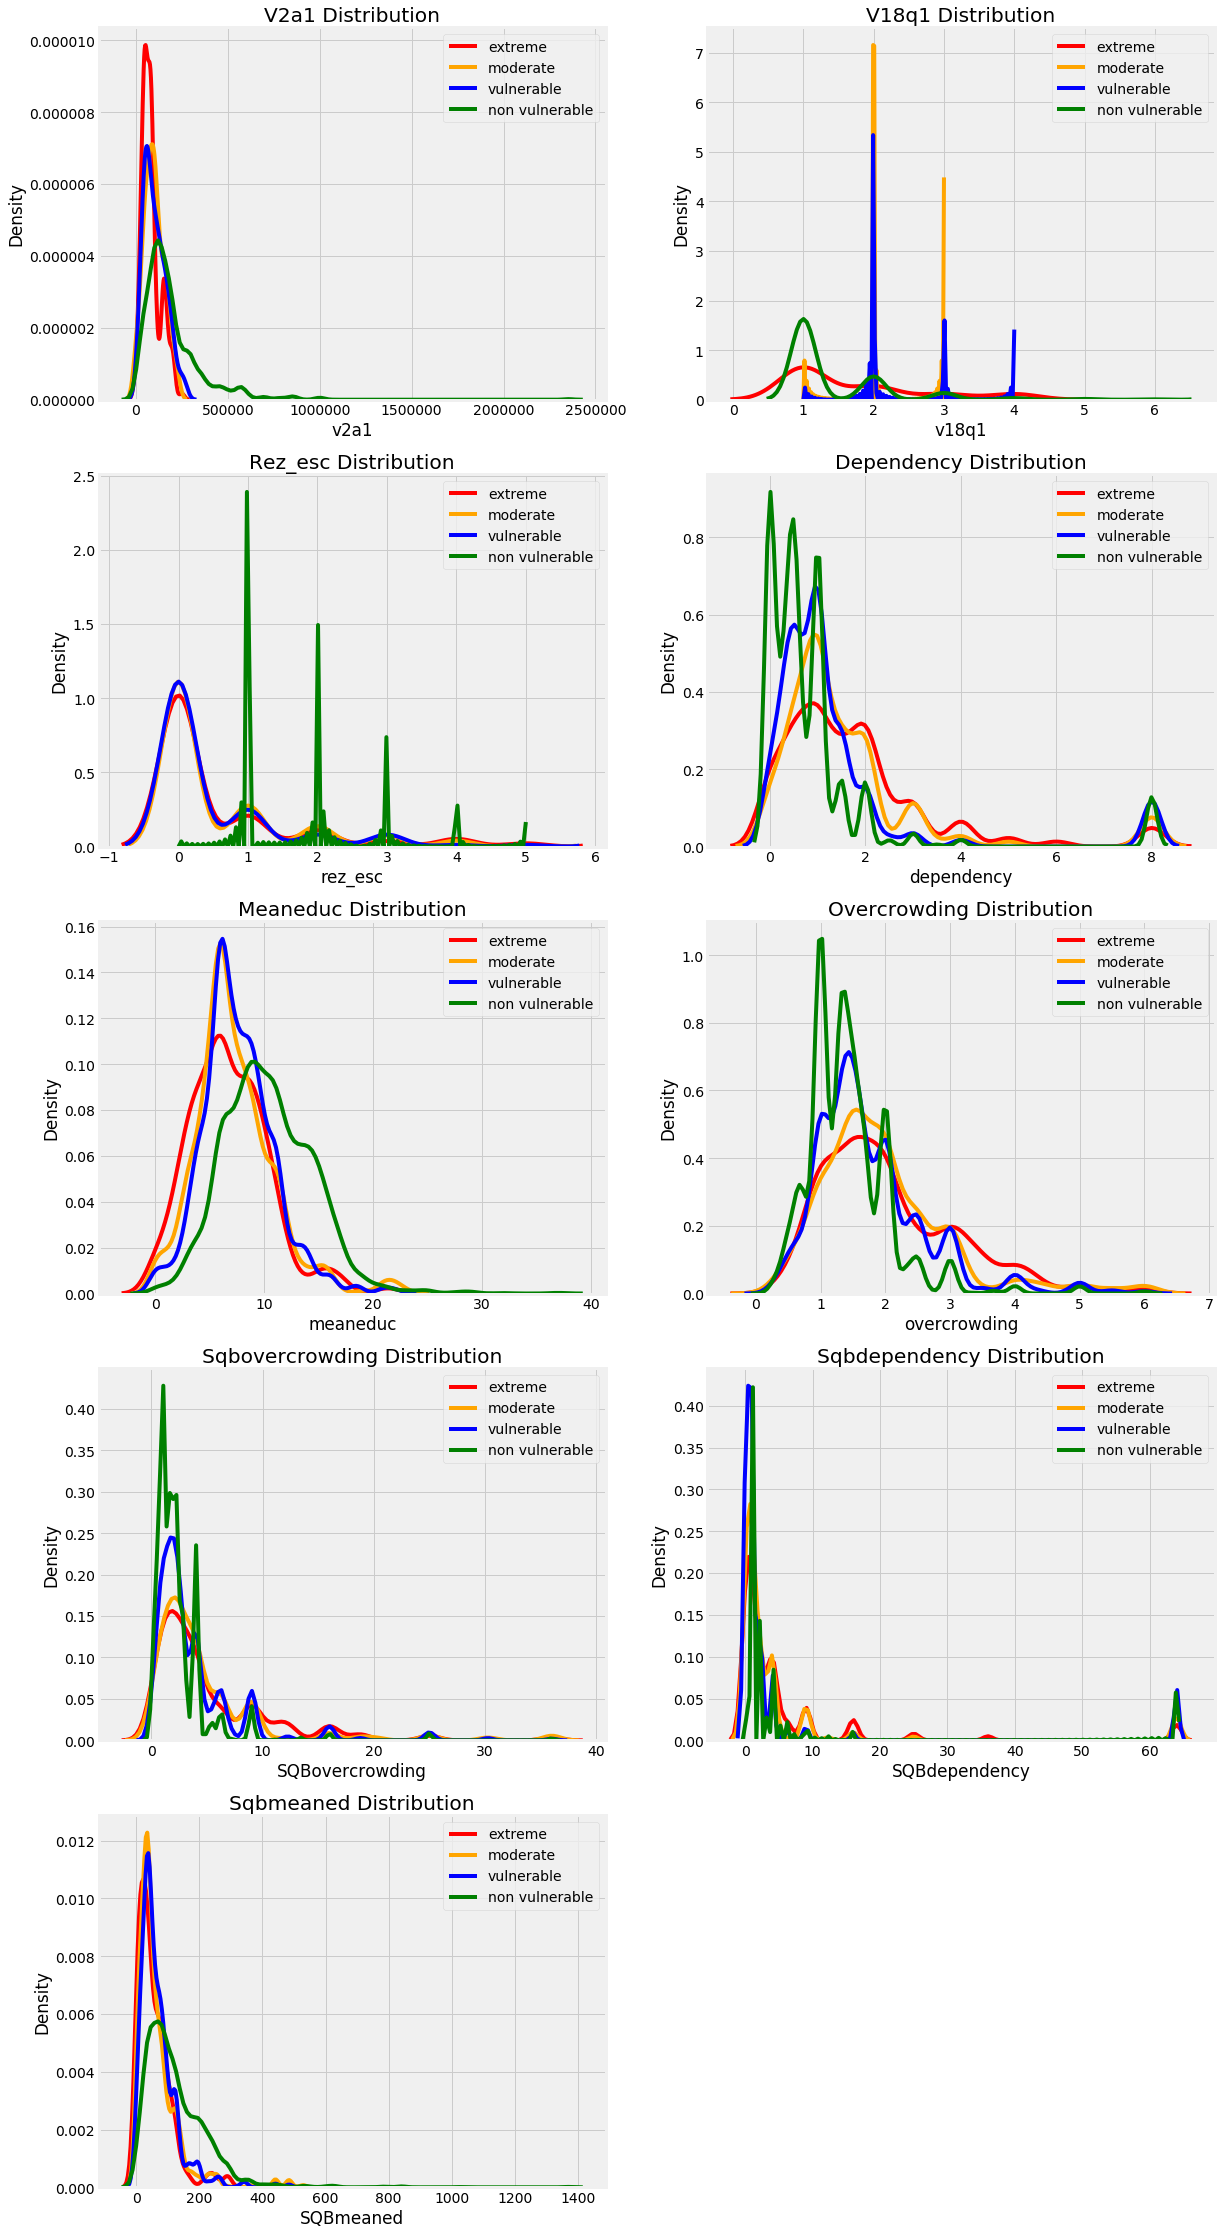

In [15]:
plt.figure(figsize = (20, 16))
plt.style.use('fivethirtyeight')

# Color mapping
colors = collections.OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = collections.OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# Iterate through the float columns
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(5, 2, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

## Missing Values
An important thing to consider is the missing values that may be present so I will check for that and make some corrections based on which columns have missing values.

In [16]:
# Number of missing in each column
missing = pd.DataFrame(train.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / train.shape[0]

missing.sort_values('percent', ascending = False).head(10)

,total,percent
rez_esc,7928,0.829549
v18q1,7342,0.768233
v2a1,6860,0.717798
SQBmeaned,5,0.000523
meaneduc,5,0.000523
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000
idhogar,0,0.000000


There don't seem to be a lot of columns with missing values but there are definitely some corrections that need to be made. The way we fill them in will be different depending on the columns so we will have to look at the documentation for some instructions or make some decisions for how to treat those.
* v18q1: NaN means that the family does not have a tablet so we can fill in a 0 there
* v2a1: Many of the people that don't have rent payments seem to own their homes
* rez_esc: This is about years of education and there are issues I will discuss later
* meaneduc: mean years of education of adults in the home we will look into this more
* SQBmeaned: the square of the above variable

In [17]:
train.v18q1.fillna(0, inplace=True) # filling in 0 for missing tablet columns

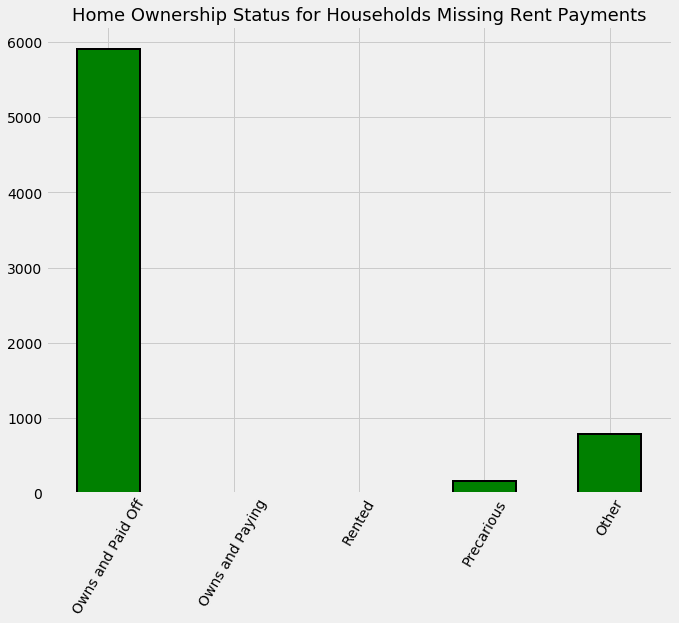

In [18]:
# Variables indicating home ownership
own_variables = [x for x in train if x.startswith('tipo')]


# Plot of the home ownership variables for home missing rent payments
train.loc[train['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (10, 8), color = 'green',
                                                                edgecolor = 'k', linewidth = 2);
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

So most of the missing values for rent payments are really just that people own their homes so we can just set that to zero. I can't find any explanation for why the other values would be missing so I will make a dummy variable for that as it is likely non-random that the values are missing.

In [19]:
# Fill in households that own the house with 0 rent payment
train.loc[(train['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
train['v2a1-missing'] = train['v2a1'].isnull()

# filling in the unknowns with the mean value
train.v2a1.fillna(np.mean(train.v2a1), inplace=True)

train['v2a1-missing'].value_counts()

False    8608
True      949
Name: v2a1-missing, dtype: int64

The education variable is a more complicated one but from the discussions by others aout the data they have found that the variable is only labelled for people between the ages of 7 and 19. I will assume that the missing values out of that range should be zero and then I will make a dummy like I did for the previous variable because the missing values probably mean something but I just don't know what it is. Luckily, the machine learning we are doing might be able to pick up on a correlation there even if we can't.  
There is also some mislabelling based on what others have found. The variable has a maximum value fo five but some are over that so I will just move those values down to 5.

In [20]:
# filling in the zeroes for the missing values that are not in the range 7 to 19
train.loc[((train['age'] > 19) | (train['age'] < 7)) & (train['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
train['rez_esc-missing'] = train['rez_esc'].isnull()

# filling in unknown values with the mean
train.rez_esc.fillna(np.mean(train.rez_esc), inplace=True)

# fixing mislabelled data
train.loc[train['rez_esc'] > 5, 'rez_esc'] = 5

There are also those 5 observations with the missing data on mean education of adults in the home that I will look at just for good measure. As 5 observations probably won't change a whole lot given our sample size and I can't find out mcuh about why they would be missing I will just fill in with the mean value there.

In [21]:
train.meaneduc.fillna(np.mean(train.meaneduc), inplace=True)
train.SQBmeaned.fillna(np.mean(train.meaneduc)**2, inplace=True)

# just to make sure we got all of the missing variables resolved
# Number of missing in each column
missing = pd.DataFrame(train.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / train.shape[0]

missing.sort_values('percent', ascending = False).head(10)

,total,percent
v2a1,0,0.0
hacdor,0,0.0
parentesco11,0,0.0
parentesco12,0,0.0
idhogar,0,0.0
hogar_nin,0,0.0
hogar_adul,0,0.0
hogar_mayor,0,0.0
hogar_total,0,0.0
dependency,0,0.0


## Feature Engineering
Now that the variables we have are clean let's get them ready for modelling with some engineering. Let's look at if we actually need some of the variables as the other people that have done the challenge say there are some variables that we might want to just drop.

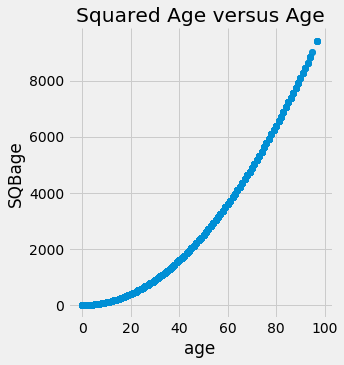

In [22]:
sns.lmplot('age', 'SQBage', data = train, fit_reg=False);
plt.title('Squared Age versus Age');

As we see the squared variables are pretty correlated and I won't really be using linear models so there isn't really a big advantage from having these so I will drop the squared variables to prevent overfitting and they won't add much in the way fo predictive power so we can just save the time on training by not having them.

In [23]:
#train.drop(columns = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
#        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq'], inplace=True)

One thing that we can do is consolidate some of the dummies into ordinal variables as they seem to have an order with poor, regular and good for the variables about walls, rooves and floors.

In [24]:
train['walls'] = np.argmax(np.array(train[['epared1', 'epared2', 'epared3']]),
                           axis = 1)
train['roof'] = np.argmax(np.array(train[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)
train['floor'] = np.argmax(np.array(train[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)

Now that we have this we can look at the combination of all of these three variables as well to get some sort of measure of overall house quality.

In [25]:
train['walls+roof+floor'] = train['walls'] + train['roof'] + train['floor']

We can also add a feature to measure if a house is missing some key things that we would expect a home to have which should eb a pretty good indicator for poverty. Similarly to a penalty, we can add a bonus for having things like refrigerator tablets and televisions.

In [26]:
train['warning'] = 1 * (train['sanitario1'] + 
                         train['pisonotiene'] + 
                         train['abastaguano'] + 
                         (train['cielorazo'] == 0))

train['bonus'] = 1 * (train['refrig'] + 
                      train['computer'] + 
                      (train['v18q1'] > 0) + 
                      train['television'])

Another thing that will help squeeze some more predictive power out of a few of the variables will be the number of certain things per person in the household as 2 rooms is different for two people than five people.

In [27]:
train['phones-per-capita'] = train['qmobilephone'] / train['tamviv']
train['tablets-per-capita'] = train['v18q1'] / train['tamviv']
train['rooms-per-capita'] = train['rooms'] / train['tamviv']
train['rent-per-capita'] = train['v2a1'] / train['tamviv']

The number of years of education is going to be different for differnet aged people so getting the amount of education divided by age should be a useful feature as well as the number of mobile phones and tablets together.

In [28]:
train['escolari/age'] = train['escolari'] / train['age']
train['escolari/age'].fillna(0, inplace=True) # for the ones that have a zero division that creates NaN
train['tech'] = train['v18q'] + train['mobilephone']

## Modelling
Now the fun part. I will make a train and test out of the training data as we aren't able to submit it so I can assess the quality of the model and check for overfitting. I ran a quick logit before the data cleaning and feature engineering as a baseline score to see how well the models do.  
F1 scores:
* micro 0.6571099717484566
* macro 0.3165340400405846

In [29]:
x_train, x_test, y_train, y_test = train_test_split(train.drop(columns=['Target', 'idhogar']), train.Target,
                                                    test_size=0.33, random_state=42)

In [30]:
logit = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=3500)
logit.fit(x_train, y_train)
f1_score(y_test, logit.predict(x_test), average='macro')

/Users/branchflower/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.28056464054957075

In [ ]:
clf = SVC()
gridsearch = GridSearchCV(clf, {"C": [0.2, 0.5, 0.7], "kernel": ['linear', 'poly', 'rbf'], 
                                'degree': [1, 2, 3], 'gamma': [1, 5, 11]}, scoring='f1',
                         cv=4, verbose=1)
gridsearch.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 81 candidates, totalling 324 fits


In [ ]:
missing = pd.DataFrame(train.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / train.shape[0]

missing.sort_values('percent', ascending = False).head(10)

In [ ]:
# Baseline F1 score, logit 
# micro 0.6571099717484566
# macro 0.3165340400405846